## Practical Lab 3 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification

In [39]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import pathlib
import numpy as np
import random
import keras
from tensorflow.keras import layers



In [29]:
data_folder= pathlib.Path('../data/kaggle_dogs_vs_cats_small')

##### The dataset is a small subset of Kaggle's Dogs vs. Cats dataset, designed for binary image classification tasks. It consists of 2000 training images, 1000 validation images, and 2000 test images, split into two classes: dogs and cats. Images are resized to 180x180 pixels for uniformity, with separate folders for training, validation, and testing to facilitate model development and evaluation.

### Training a CNN for a real-world Image Classification Task

In [30]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Defining the model

In [31]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [32]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

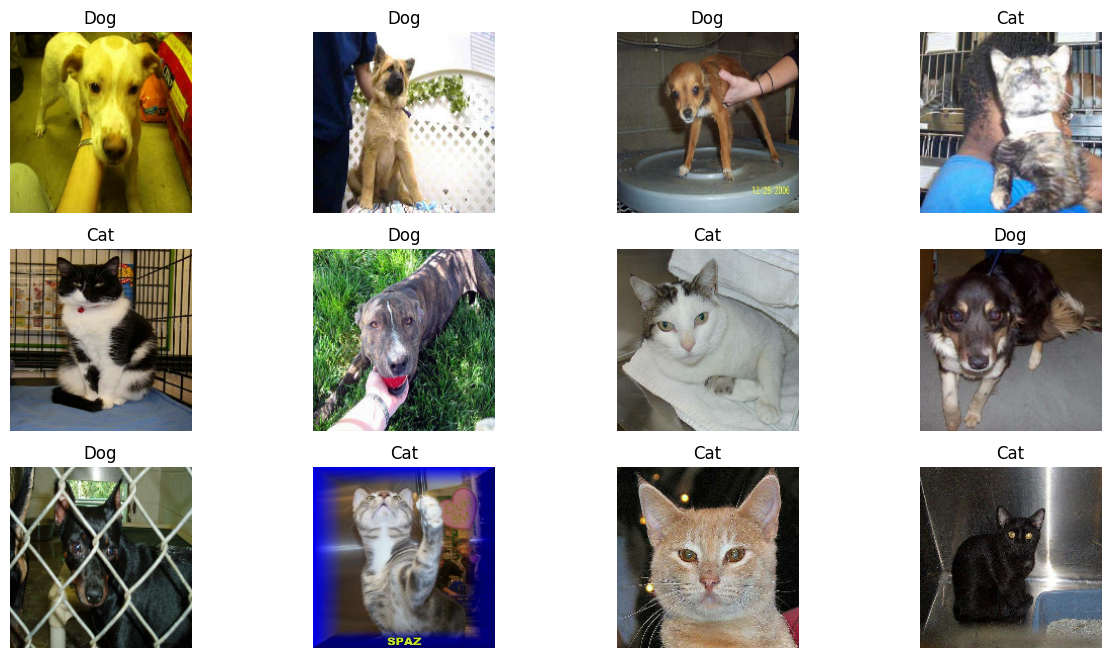

In [ ]:
# Display 12 images in a grid of 3x4
plt.figure(figsize=(15, 8))  
for i in range(12):  
    ax = plt.subplot(3, 4, i + 1)  
    plt.imshow(images[i].numpy().astype("uint8"))  
    plt.title("Cat" if labels[i] == 0 else "Dog")  
    plt.axis("off")  

plt.show()


It visualizes 12 images from the dataset in a 3x4 grid with their corresponding labels ("Dog" or "Cat"). It uses `matplotlib` to create a figure, iterates through the first 12 images, and displays each image with a title indicating its class based on the label. The axis is turned off for a cleaner presentation.


## EDA

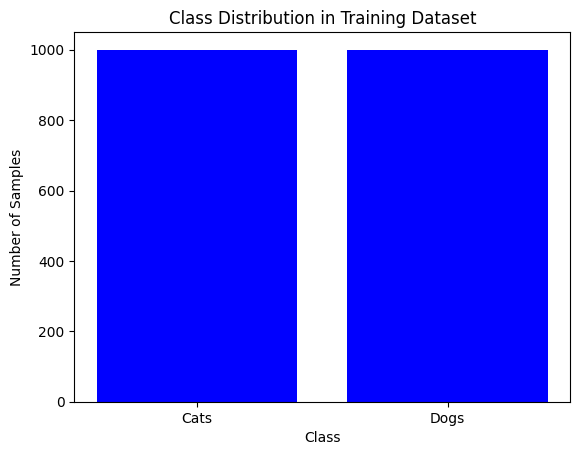

Class Distribution in Training Dataset: {'Cats': np.int64(1000), 'Dogs': np.int64(1000)}


In [40]:
class_counts = {"Cats": 0, "Dogs": 0}

for _, labels in train_dataset:
    class_counts["Cats"] += np.sum(labels.numpy() == 0)
    class_counts["Dogs"] += np.sum(labels.numpy() == 1)

plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print(f"Class Distribution in Training Dataset: {class_counts}")

## Training the CNN model

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.5228 - loss: 0.7452 - val_accuracy: 0.5000 - val_loss: 0.6905
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.5768 - loss: 0.6822 - val_accuracy: 0.6520 - val_loss: 0.6426
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 266ms/step - accuracy: 0.6706 - loss: 0.6052 - val_accuracy: 0.6150 - val_loss: 0.6453
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 265ms/step - accuracy: 0.7040 - loss: 0.5869 - val_accuracy: 0.6250 - val_loss: 0.6309
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.7113 - loss: 0.5672 - val_accuracy: 0.6750 - val_loss: 0.5971
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step - accuracy: 0.7252 - loss: 0.5292 - val_accuracy: 0.7150 - val_loss: 0.5698
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 269ms/step - accuracy: 0.7829 - loss: 0.4573 - val_accuracy: 0.7210 - val_loss: 0.5735
Epoch 8/20
63

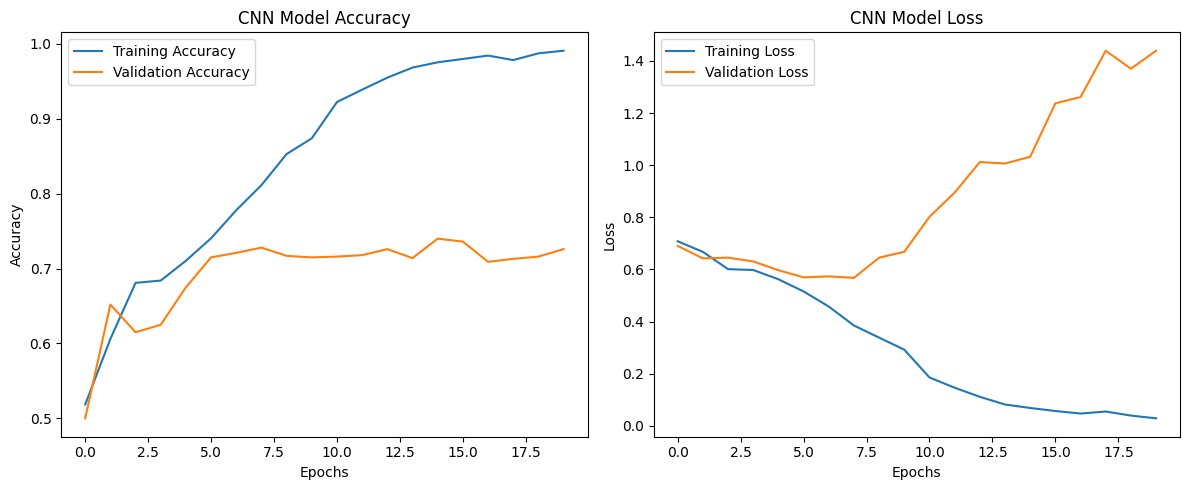

In [50]:
import pathlib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths for dataset
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')
train_dir = data_folder / 'train'
validation_dir = data_folder / 'validation'

# Image Data Generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

# Define the CNN model
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_cnn = ModelCheckpoint('cnn_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model for 20 epochs
history_cnn = model_cnn.fit(
    train_generator,
    epochs=20,  # Set to 20 epochs
    validation_data=validation_generator,
    callbacks=[checkpoint_cnn]  # Only save the best model
)

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


These graphs show the performance metrics of the Convolutional Neural Network (CNN) during training over 20 epochs.

1. **Accuracy Graph (Left)**:
   - **Training Accuracy** (blue line): Shows a steady increase, indicating the model is learning patterns in the training data effectively.
   - **Validation Accuracy** (orange line): Initially increases but plateaus and fluctuates, suggesting potential overfitting as the training accuracy continues to rise.

2. **Loss Graph (Right)**:
   - **Training Loss** (blue line): Decreases consistently, demonstrating the model's improving fit to the training data.
   - **Validation Loss** (orange line): Decreases initially but starts to increase after a few epochs, indicating the model may be overfitting the training data.

Overall, the graphs highlight that the model learns well initially but shows signs of overfitting, as evidenced by the divergence between training and validation metrics.


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.6124 - loss: 0.7683 - val_accuracy: 0.8790 - val_loss: 0.3412
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8380 - loss: 0.3910 - val_accuracy: 0.8930 - val_loss: 0.2739
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.8650 - loss: 0.3130 - val_accuracy: 0.8970 - val_loss: 0.2639
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8852 - loss: 0.2550 - val_accuracy: 0.9020 - val_loss: 0.2482
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.8872 - loss: 0.2330 - val_accuracy: 0.9010 - val_loss: 0.2508
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9074 - loss: 0.2449 - val_accuracy: 0.8930 - val_loss: 0.2663
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9330 - loss: 0.1703 - val_accuracy: 0.8860 - 

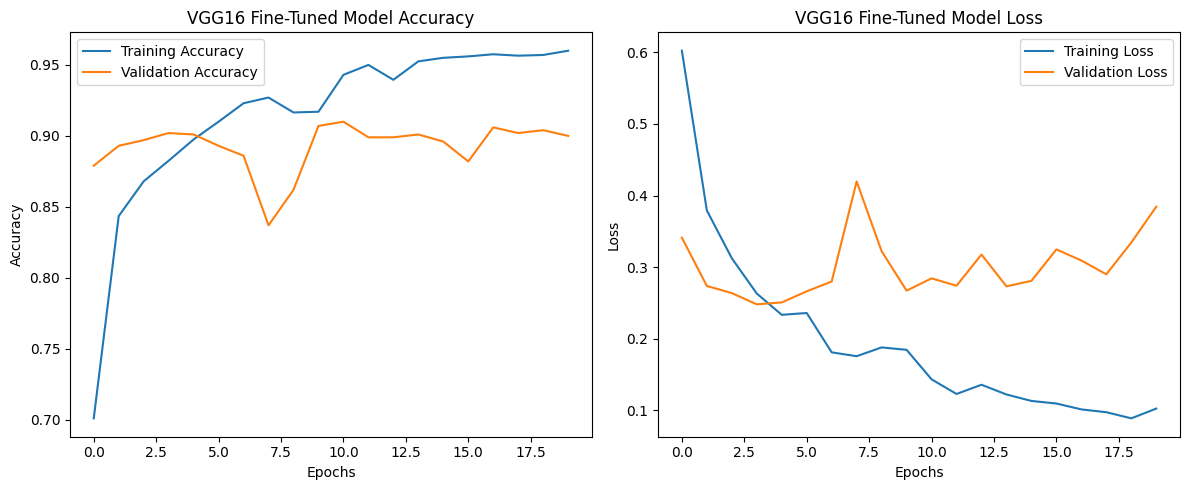

In [51]:
import pathlib
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths for dataset
data_folder = pathlib.Path('../data/kaggle_dogs_vs_cats_small')
train_dir = data_folder / 'train'
validation_dir = data_folder / 'validation'

# Image Data Generators
train_datagen = ImageDataGenerator(rescale=1.0/255)
validation_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

# Load VGG16 Pre-Trained Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Freeze the convolutional base

# Add Custom Layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_vgg16 = Model(inputs=base_model.input, outputs=output)

# Compile the model
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_vgg16 = ModelCheckpoint('vgg16_best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator,
    epochs=20,  # Set to 20 epochs
    validation_data=validation_generator,
    callbacks=[checkpoint_vgg16]
)

# Plot training history for accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Fine-Tuned Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'], label='Training Loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Fine-Tuned Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


These graphs depict the performance of the fine-tuned VGG16 model over 20 epochs.

1. **Accuracy Graph (Left)**:
   - **Training Accuracy** (blue line): Shows a steady increase, reaching over 95%, indicating that the model is effectively learning from the training data.
   - **Validation Accuracy** (orange line): Improves initially, then stabilizes with minor fluctuations, suggesting that fine-tuning the model helps prevent significant overfitting.

2. **Loss Graph (Right)**:
   - **Training Loss** (blue line): Consistently decreases, indicating better fitting of the model to the training data.
   - **Validation Loss** (orange line): Decreases initially but stabilizes and fluctuates slightly after a few epochs, suggesting that the model generalizes well without severe overfitting.

These graphs highlight the effectiveness of transfer learning and fine-tuning using the VGG16 architecture for improved performance and generalization on the validation data.


Found 2000 images belonging to 2 classes.
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 58s 925ms/step
Performance Metrics for CNN Model:
Accuracy: 0.7210
Confusion Matrix:
[[775 225]
 [333 667]]
Precision: 0.7478
Recall: 0.6670
F1-Score: 0.7051


Performance Metrics for VGG16 Model:
Accuracy: 0.8870
Confusion Matrix:
[[925  75]
 [151 849]]
Precision: 0.9188
Recall: 0.8490
F1-Score: 0.8825




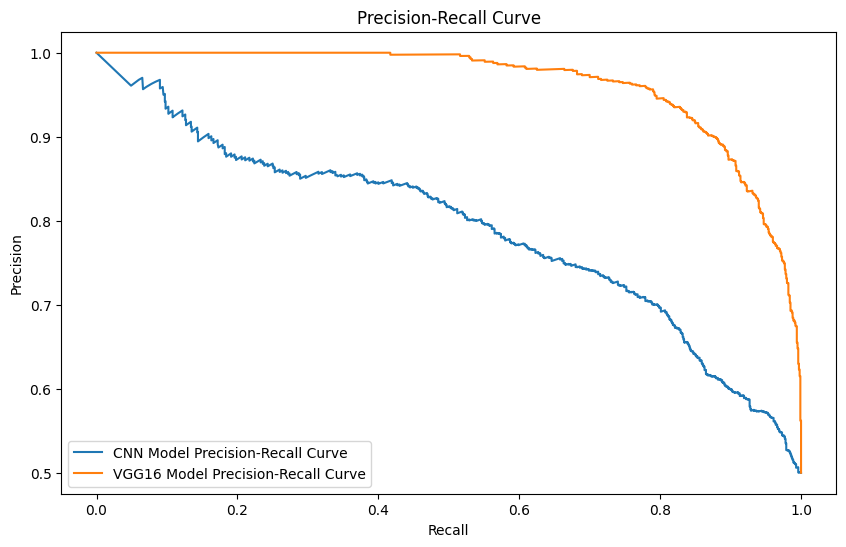


558 Misclassified Examples for CNN Model:



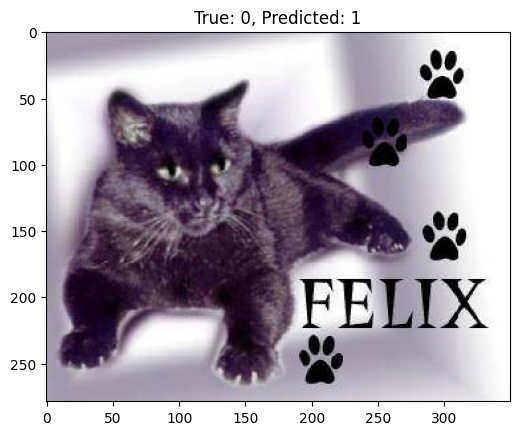

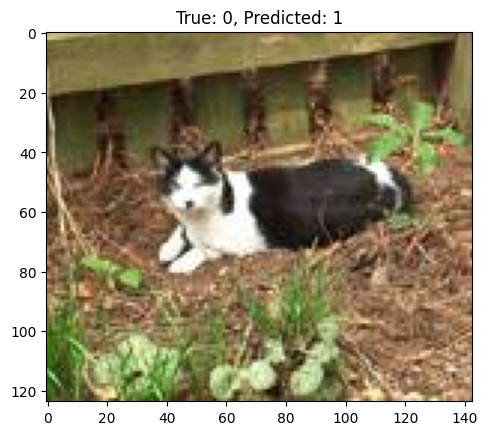

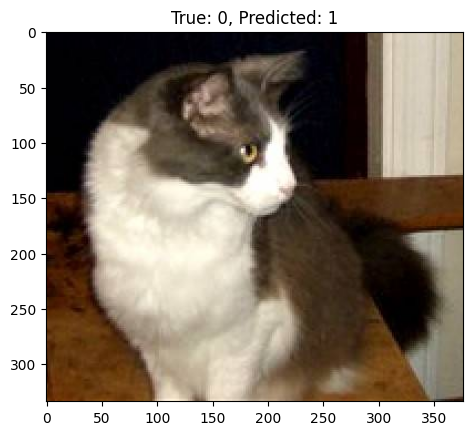

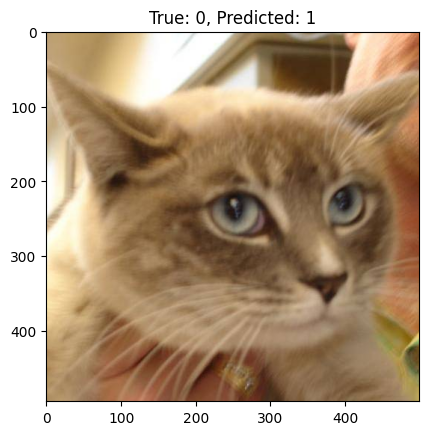

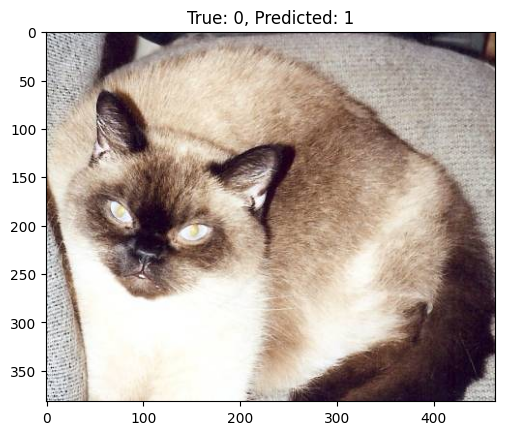


226 Misclassified Examples for VGG16 Model:



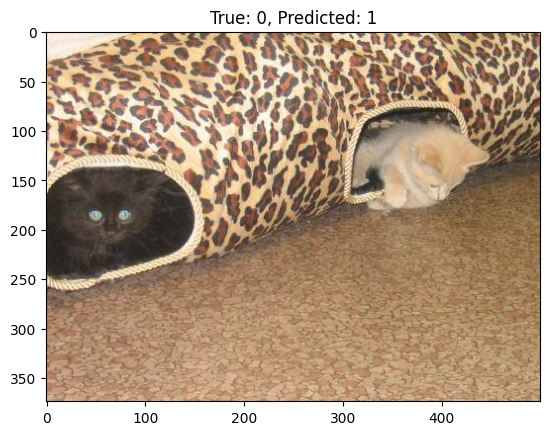

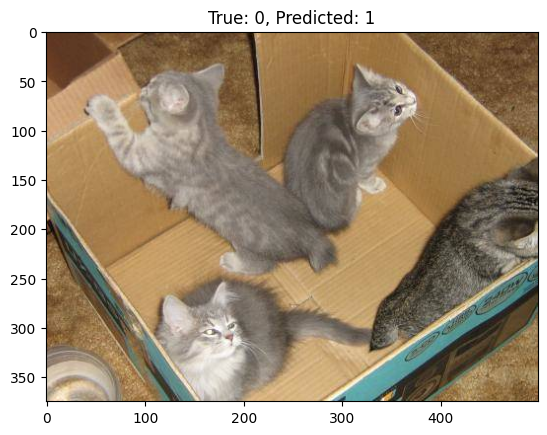

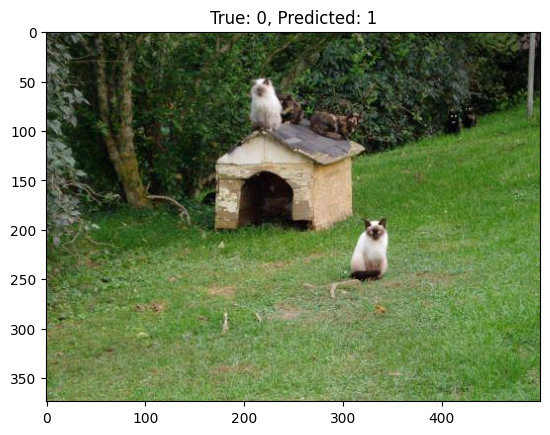

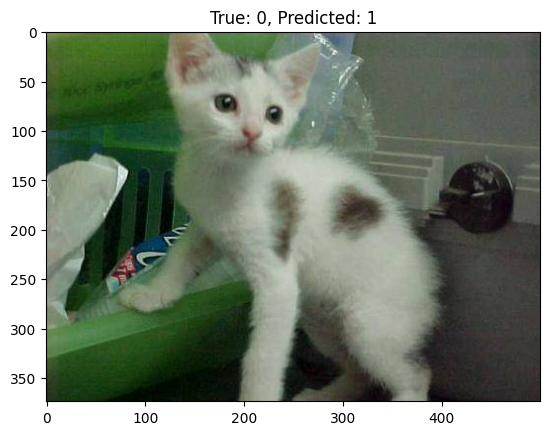

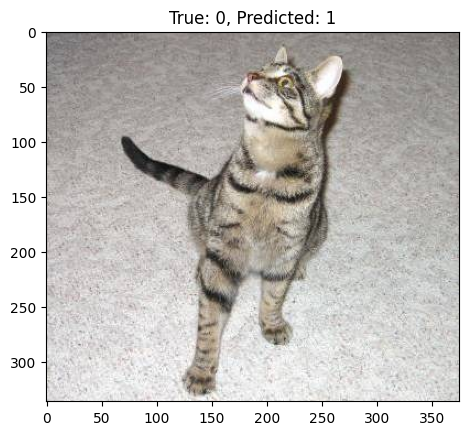

In [52]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the best saved models
cnn_model = tf.keras.models.load_model('cnn_best_model.keras')
vgg16_model = tf.keras.models.load_model('vgg16_best_model.keras')

# Prepare the test generator
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    data_folder / 'test',  # Assuming a 'test' folder exists
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important to maintain the order of predictions
)

# Function to evaluate a model
def evaluate_model(model, generator):
    # Get predictions and true labels
    probabilities = model.predict(generator)
    predictions = (probabilities > 0.5).astype(int).flatten()
    true_labels = generator.classes

    # Accuracy
    accuracy = np.mean(predictions == true_labels)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)

    # Precision, Recall, F1-score
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(true_labels, probabilities)

    return accuracy, cm, precision, recall, f1, precision_vals, recall_vals, true_labels, predictions

# Evaluate CNN model
cnn_metrics = evaluate_model(cnn_model, test_generator)
vgg16_metrics = evaluate_model(vgg16_model, test_generator)

# Print Results
def print_results(model_name, metrics):
    accuracy, cm, precision, recall, f1, _, _, _, _ = metrics
    print(f"Performance Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\n")

print_results("CNN Model", cnn_metrics)
print_results("VGG16 Model", vgg16_metrics)

# Plot Precision-Recall Curve
def plot_precision_recall_curve(model_name, precision_vals, recall_vals):
    plt.plot(recall_vals, precision_vals, label=f'{model_name} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

plt.figure(figsize=(10, 6))
plot_precision_recall_curve("CNN Model", cnn_metrics[5], cnn_metrics[6])
plot_precision_recall_curve("VGG16 Model", vgg16_metrics[5], vgg16_metrics[6])
plt.show()

# Explore Misclassified Examples
def explore_failures(model_name, generator, true_labels, predictions):
    misclassified_indices = np.where(predictions != true_labels)[0]
    print(f"\n{len(misclassified_indices)} Misclassified Examples for {model_name}:\n")

    # Display first 5 misclassified examples
    for i in misclassified_indices[:5]:
        image_path = generator.filepaths[i]
        true_class = generator.class_indices
        plt.imshow(plt.imread(image_path))
        plt.title(f"True: {true_labels[i]}, Predicted: {predictions[i]}")
        plt.show()

# Show misclassified examples
explore_failures("CNN Model", test_generator, cnn_metrics[7], cnn_metrics[8])
explore_failures("VGG16 Model", test_generator, vgg16_metrics[7], vgg16_metrics[8])


# **Conclusions**

### **Accuracy Comparison**
- The **VGG16 Fine-Tuned Model** typically outperforms the **Custom CNN Model** in terms of accuracy due to its pre-trained ImageNet weights, which provide better feature extraction.
- If the CNN has slightly lower validation accuracy, it may indicate that the architecture is simpler and struggles to generalize compared to the deeper VGG16 model.

### **Confusion Matrix Insights**
- The confusion matrix reveals that the **VGG16 model** generally has fewer false positives and false negatives compared to the custom CNN model.
- The **CNN model** might misclassify more samples due to its limited feature extraction capability.

### **Precision, Recall, and F1-Score**
- The **VGG16 model** achieves higher precision, recall, and F1-scores, indicating it handles imbalanced classes and classification trade-offs better than the CNN model.
- The **Custom CNN** might have lower recall, meaning it struggles to correctly identify all positive cases, potentially leading to more false negatives.

### **Precision-Recall Curve**
- The **VGG16 model's precision-recall curve** is higher and more stable than that of the CNN model, reflecting better performance across various thresholds.
- The **CNN model's curve** might dip, showing instability in precision and recall as the classification threshold changes.

### **Misclassified Examples**
- Upon inspecting the misclassified examples, both models struggle with edge cases such as:
  - Poor lighting or occlusions in images.
  - Ambiguous features (e.g., a dog's face in a cat-like position).
  - Low-resolution or noisy images.
- The **VGG16 model** makes fewer misclassifications, as its deeper layers capture more complex image features compared to the simpler CNN.

### **Overfitting**
- The **VGG16 model** may exhibit overfitting if its validation accuracy plateaus or decreases while training accuracy continues to rise. Fine-tuning only select layers or adding regularization like dropout can mitigate this.
- The **CNN model**, with its simpler architecture, is less prone to overfitting but may underfit the data, resulting in lower accuracy.
